In [60]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import *
import math
from utils import *
import seaborn as sns
from scipy import stats

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
edau = EDAUtils()
statsu = StatsUtils()

In [63]:
# Set up paths
script_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
tableu_dir = os.path.join(root_dir, 'tableau')
porcessed_data_dir = os.path.join(script_dir, 'processed_data')

In [64]:
k = 3
eps = 3.0 
n_rows = 200
time_periods = 500
# Load labeled data
labeled_scenarios_df = pd.read_csv(os.path.join(porcessed_data_dir, f'bardis_ensemble_python_ver_{n_rows}_{time_periods}_k{k}_eps{eps}.csv'))
labeled_scenarios_df

,Resources,Economy,Bureaucracy,Pollution,time,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.000000,0.100000,1.000000e-02,0.001000,0.0,1.0,1,0
1,0.999745,0.100337,1.004096e-02,0.001177,0.2,1.0,1,0
2,0.999487,0.100677,1.008217e-02,0.001354,0.4,1.0,1,0
3,0.999225,0.101019,1.012363e-02,0.001532,0.6,1.0,1,0
4,0.998961,0.101363,1.016535e-02,0.001710,0.8,1.0,1,0
...,...,...,...,...,...,...,...,...
500195,0.021380,0.099817,5.000838e-48,1.054658,499.2,200.0,1,0
500196,0.021382,0.099816,4.748379e-48,1.054661,499.4,200.0,1,0
500197,0.021383,0.099816,4.508664e-48,1.054664,499.6,200.0,1,0
500198,0.021385,0.099816,4.281050e-48,1.054667,499.8,200.0,1,0


In [65]:
# Create a test subset of the data
test_df = labeled_scenarios_df[labeled_scenarios_df['run_id'] < 6].copy()
test_df

,Resources,Economy,Bureaucracy,Pollution,time,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.000000,0.100000,1.000000e-02,0.001000,0.0,1.0,1,0
1,0.999745,0.100337,1.004096e-02,0.001177,0.2,1.0,1,0
2,0.999487,0.100677,1.008217e-02,0.001354,0.4,1.0,1,0
3,0.999225,0.101019,1.012363e-02,0.001532,0.6,1.0,1,0
4,0.998961,0.101363,1.016535e-02,0.001710,0.8,1.0,1,0
...,...,...,...,...,...,...,...,...
12500,0.021769,0.105602,4.704882e-37,1.033822,499.2,5.0,1,0
12501,0.021767,0.105601,4.519020e-37,1.033827,499.4,5.0,1,0
12502,0.021765,0.105601,4.340499e-37,1.033833,499.6,5.0,1,0
12503,0.021764,0.105601,4.169030e-37,1.033838,499.8,5.0,1,0


## Label Experimental Design and EDA

In [66]:
# Load exp_design data
exp_design_df = pd.read_csv(os.path.join(tableu_dir, f'exp_design_python_ver_{n_rows}_{time_periods}.csv'))
exp_design_df.head()

,k_resources:X,ef_economy_resources_on_prod:X,ef_bureaucracy_on_prod:X,k_deprec:X,ef_pollution_on_depreciation:X,k_bureaucracy:X,ef_economy_on_bureaucracy:X,k_decay_bureaucracy:X,ef_pollution_on_bureaucracy:X,k_pollution:X,k_pollution_decay:X,run_id
0,1.249517,1.386374,1.230837,0.675623,1.027077,1.040327,0.918684,0.792433,0.878865,0.916658,0.606021,1
1,1.328561,0.709365,0.710927,1.490493,0.852915,0.993249,1.328989,0.675548,1.101360,1.254271,1.203816,2
2,0.890601,0.735489,1.355562,1.056827,1.002118,0.957872,1.164407,0.612596,1.445826,0.663342,1.245152,3
3,0.596990,1.164020,1.106771,1.396598,1.426853,1.218414,1.454357,0.685326,1.463259,1.346417,0.651436,4
4,0.615974,0.846711,0.509845,0.947777,1.059326,0.952646,1.311282,1.123705,0.795992,1.132922,1.344677,5


In [67]:
# Create a df that has the unique run ids and the corresponding cluster id
runs_cluster_mapping = labeled_scenarios_df.groupby('run_id')[['kmeans_cluster_id', 'dbscan_cluster_id']].first().reset_index()
runs_cluster_mapping

,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.0,1,0
1,2.0,1,0
2,3.0,1,0
3,4.0,1,0
4,5.0,1,0
...,...,...,...
195,196.0,0,0
196,197.0,0,-1
197,198.0,0,-1
198,199.0,1,0


In [68]:
# Merge the exp_design_df with the runs_cluster_mapping to get the cluster ids for each run
exp_design_df = pd.merge(exp_design_df, runs_cluster_mapping, on='run_id', how='left')
exp_design_df

,k_resources:X,ef_economy_resources_on_prod:X,ef_bureaucracy_on_prod:X,k_deprec:X,ef_pollution_on_depreciation:X,k_bureaucracy:X,ef_economy_on_bureaucracy:X,k_decay_bureaucracy:X,ef_pollution_on_bureaucracy:X,k_pollution:X,k_pollution_decay:X,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.249517,1.386374,1.230837,0.675623,1.027077,1.040327,0.918684,0.792433,0.878865,0.916658,0.606021,1,1,0
1,1.328561,0.709365,0.710927,1.490493,0.852915,0.993249,1.328989,0.675548,1.101360,1.254271,1.203816,2,1,0
2,0.890601,0.735489,1.355562,1.056827,1.002118,0.957872,1.164407,0.612596,1.445826,0.663342,1.245152,3,1,0
3,0.596990,1.164020,1.106771,1.396598,1.426853,1.218414,1.454357,0.685326,1.463259,1.346417,0.651436,4,1,0
4,0.615974,0.846711,0.509845,0.947777,1.059326,0.952646,1.311282,1.123705,0.795992,1.132922,1.344677,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.780267,1.496768,0.989642,1.073724,0.668342,0.973681,0.674095,1.348938,0.971180,0.699605,0.739932,196,0,0
196,1.010320,0.746947,1.034887,0.605017,0.697087,1.259618,0.767751,0.589836,0.759581,1.068545,1.286674,197,0,-1
197,0.878358,0.978513,0.789533,0.803129,0.517417,0.579271,0.654827,0.627689,1.319758,0.524407,0.741372,198,0,-1
198,0.769033,0.674555,0.664823,1.386386,0.798350,1.261464,1.319072,0.564614,1.324940,0.758451,0.576042,199,1,0


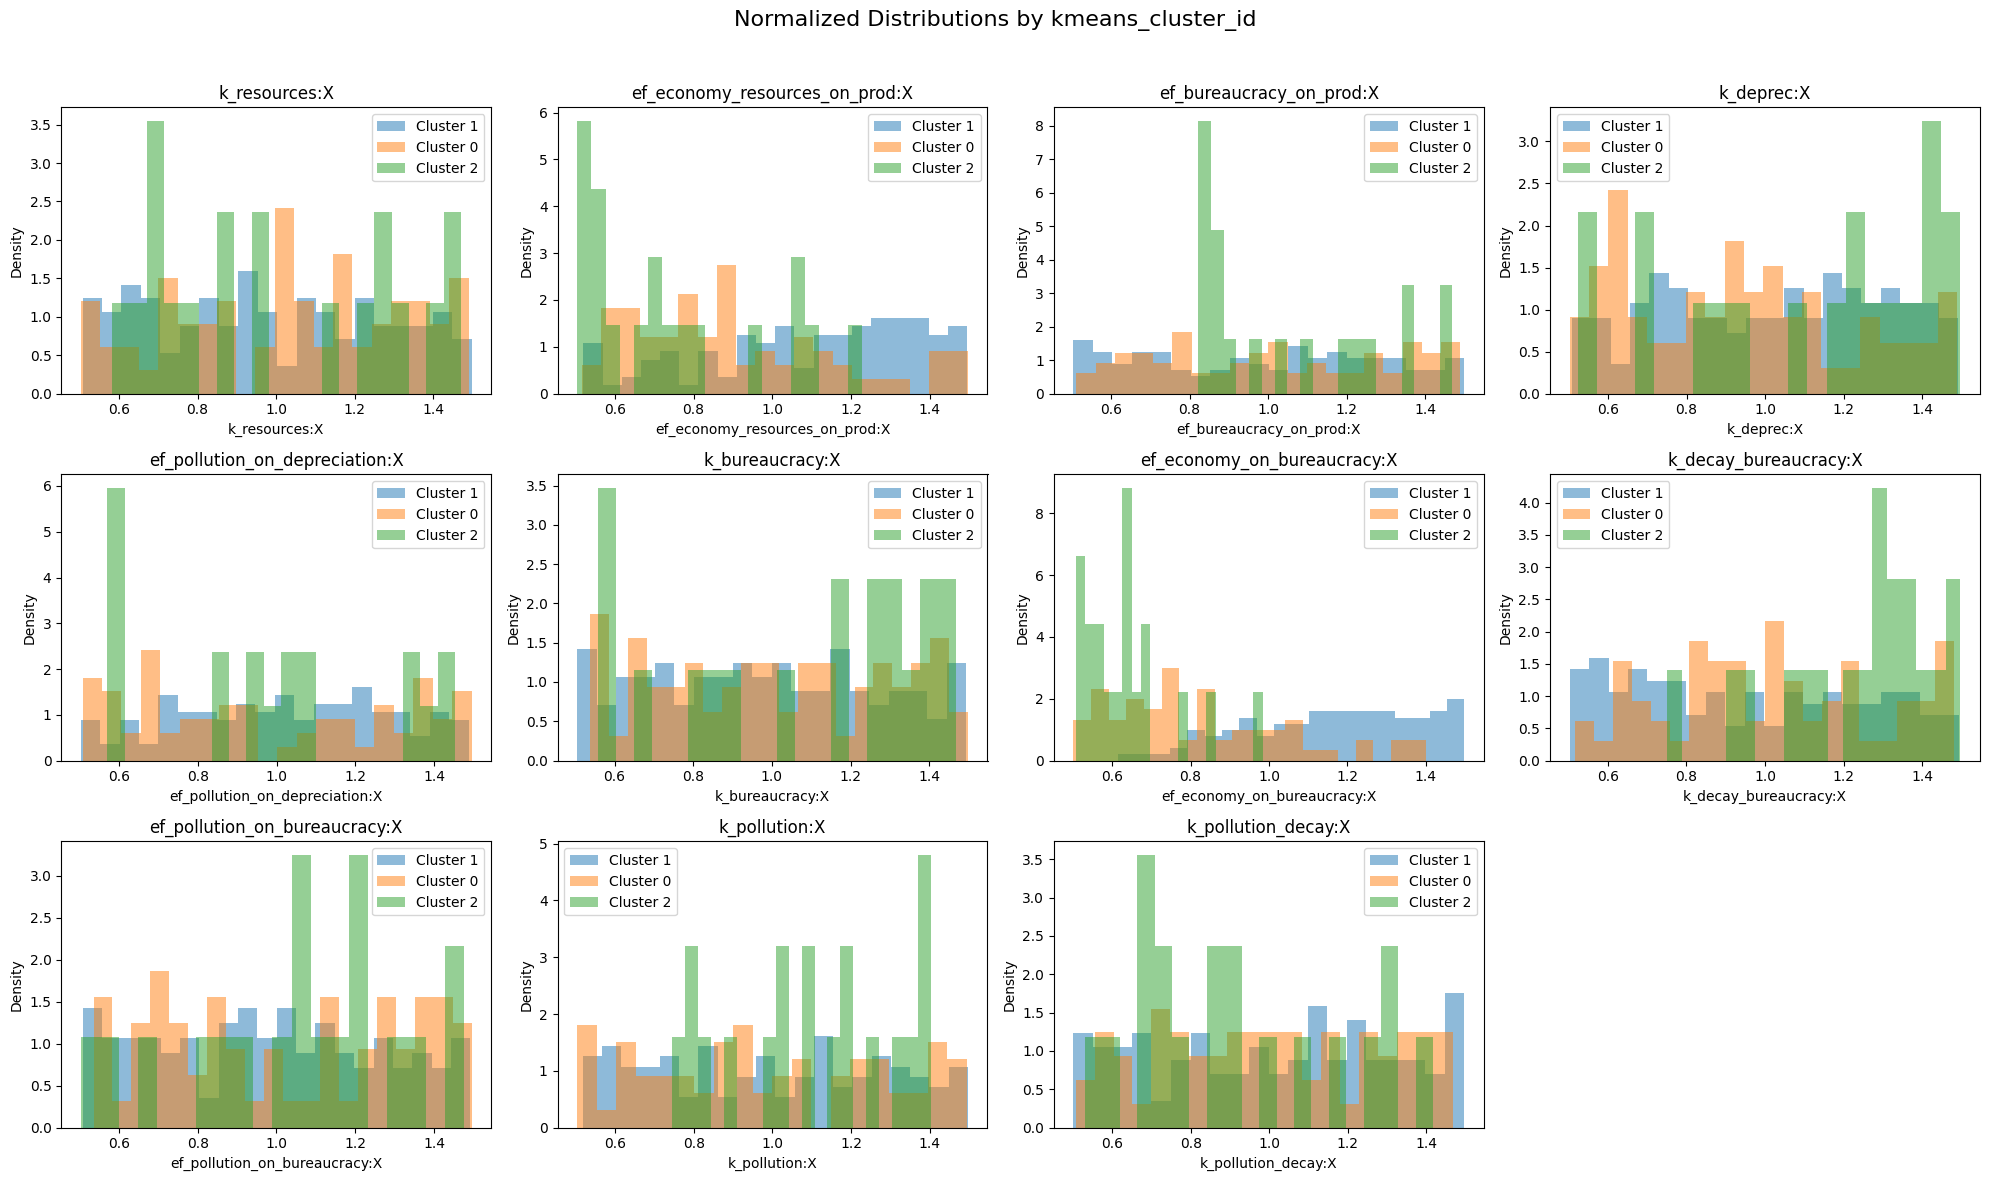

In [69]:
statsu.plot_distribution_by_cluster(exp_design_df, 'kmeans_cluster_id', density=True)

In [70]:
conf = 0.95
ci_df = statsu.compute_confidence_intervals(exp_design_df,
                                    'kmeans_cluster_id',
                                    conf)

ci_df.head()

,kmeans_cluster_id,variable,mean,lower_ci,upper_ci,n
0,0,k_resources:X,1.036611,0.966587,1.106634,67
1,0,ef_economy_resources_on_prod:X,0.898571,0.835546,0.961597,67
2,0,ef_bureaucracy_on_prod:X,1.012972,0.941265,1.084680,67
3,0,k_deprec:X,0.935966,0.866663,1.005270,67
4,0,ef_pollution_on_depreciation:X,0.972328,0.893466,1.051190,67


In [71]:
# Lists of parameters per flow
resource_inflow = ['k_resources:X']
extractive_pollution = ["k_pollution:X"]
production = ["ef_economy_resources_on_prod:X"]
depreciation = ["k_deprec:X"]
bureaucracy_creation = ["ef_economy_on_bureaucracy:X"]
bureaucracy_decay = ["k_decay_bureaucracy:X"]
pollution_abatement = ["k_pollution_decay:X"]


# Join the flow lists into a single list
resources_params = resource_inflow + production + extractive_pollution
economy_params = production + depreciation + bureaucracy_creation
bureaucracy_params = bureaucracy_creation + bureaucracy_decay
poluttion_params = depreciation + bureaucracy_decay + extractive_pollution + pollution_abatement

print(f"Resources params: {resources_params}")
print(f"Economy params: {economy_params}")
print(f"Bureaucracy params: {bureaucracy_params}")
print(f"Pollution params: {poluttion_params}")

Resources params: ['k_resources:X', 'ef_economy_resources_on_prod:X', 'k_pollution:X']
Economy params: ['ef_economy_resources_on_prod:X', 'k_deprec:X', 'ef_economy_on_bureaucracy:X']
Bureaucracy params: ['ef_economy_on_bureaucracy:X', 'k_decay_bureaucracy:X']
Pollution params: ['k_deprec:X', 'k_decay_bureaucracy:X', 'k_pollution:X', 'k_pollution_decay:X']


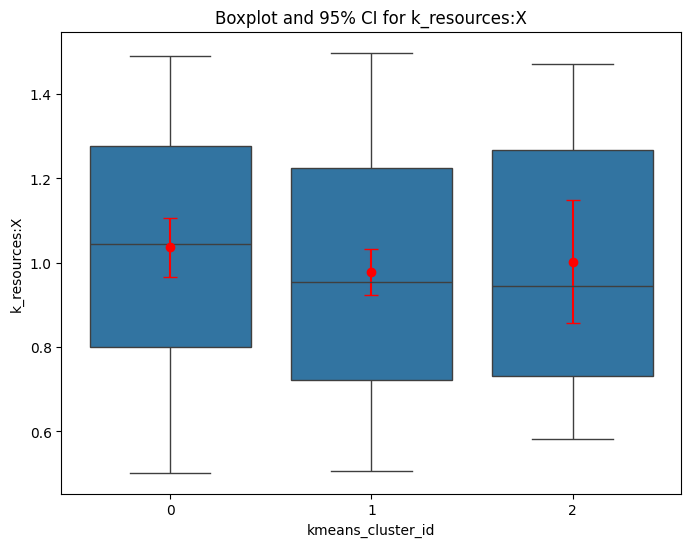

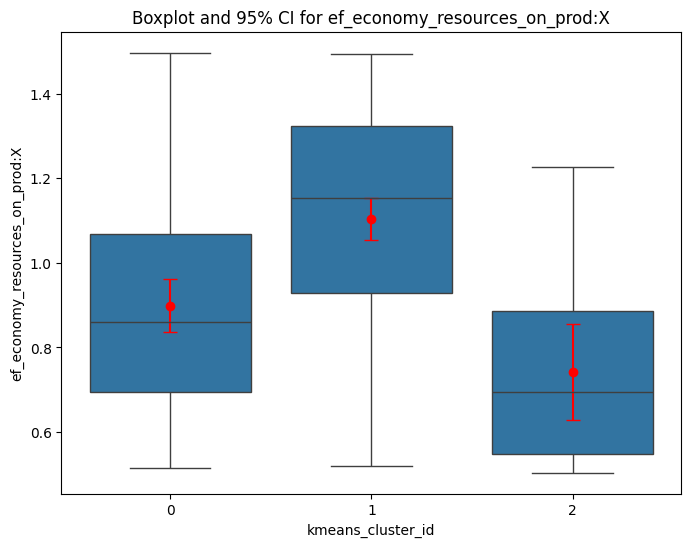

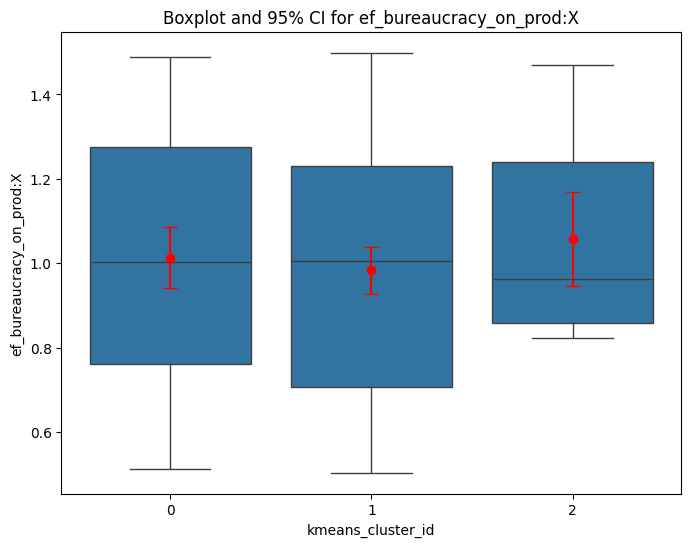

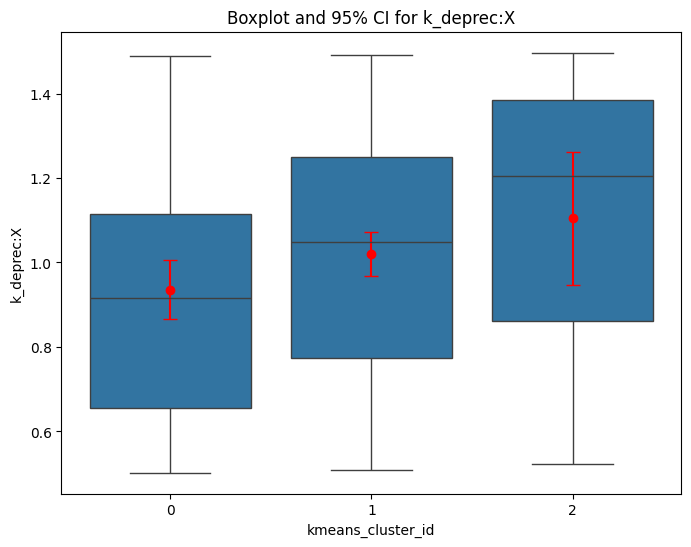

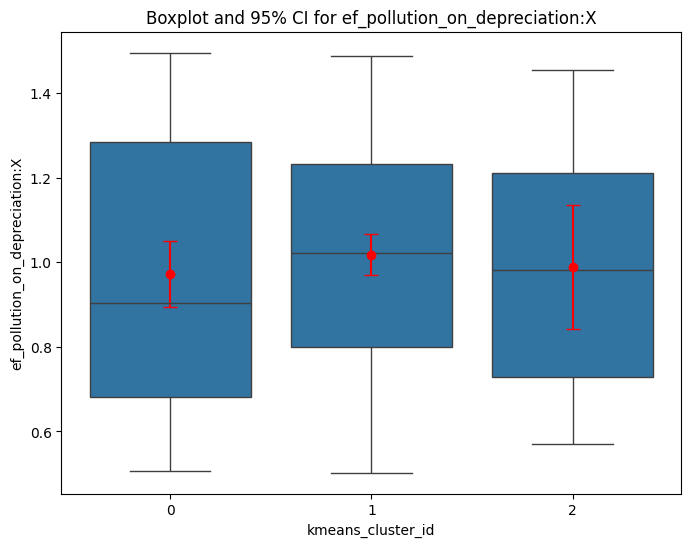

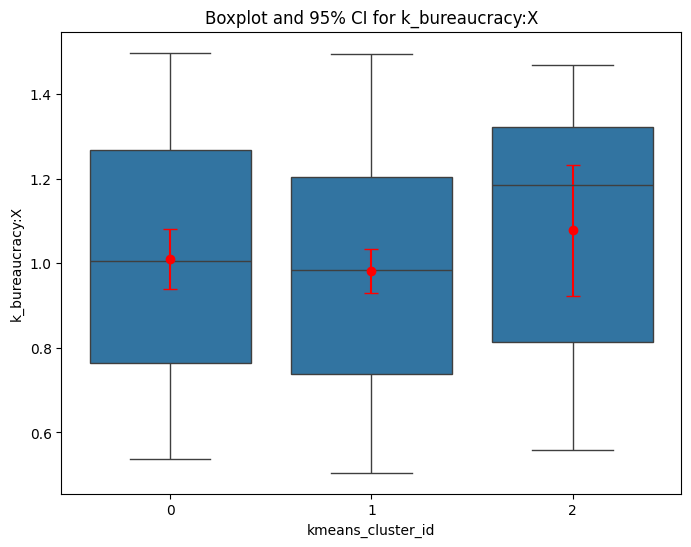

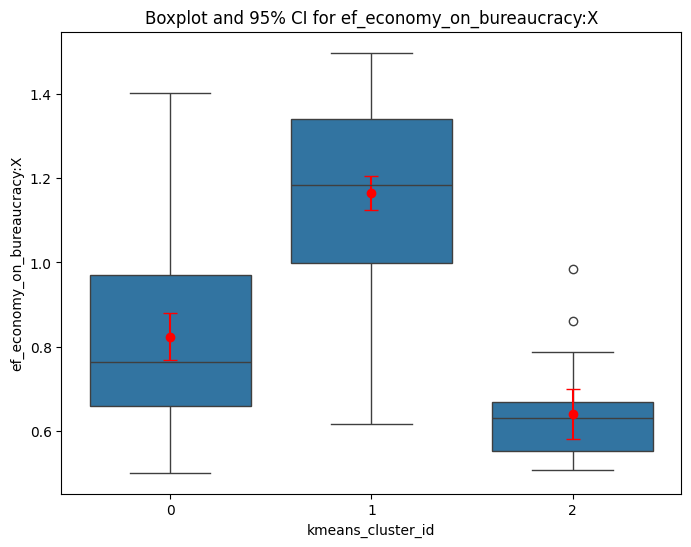

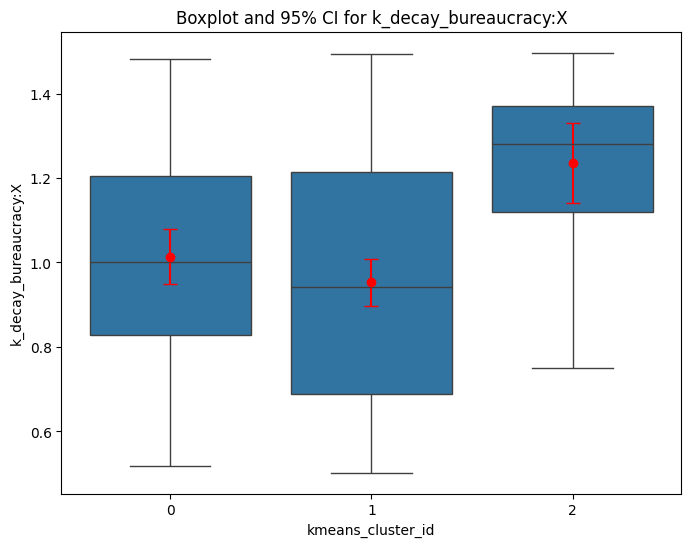

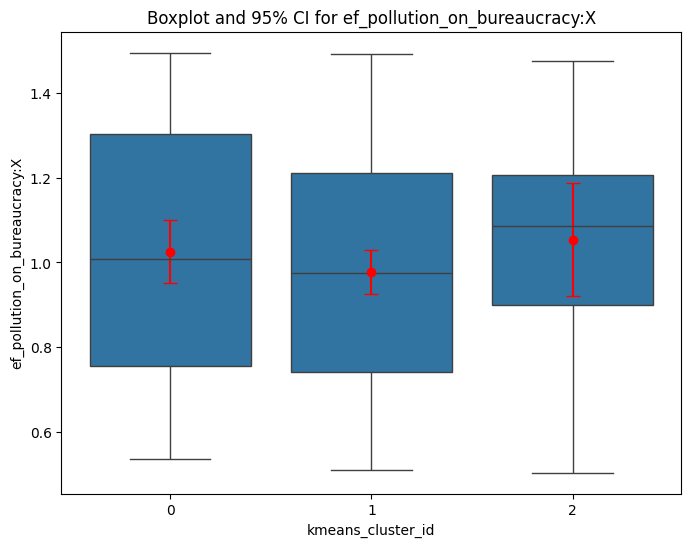

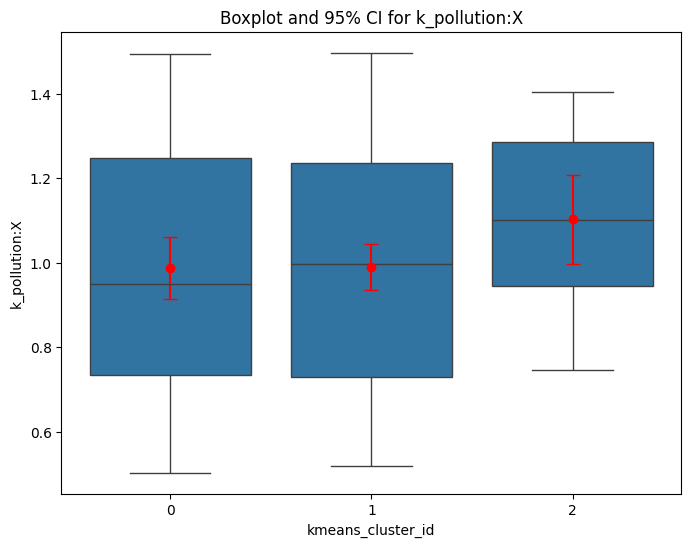

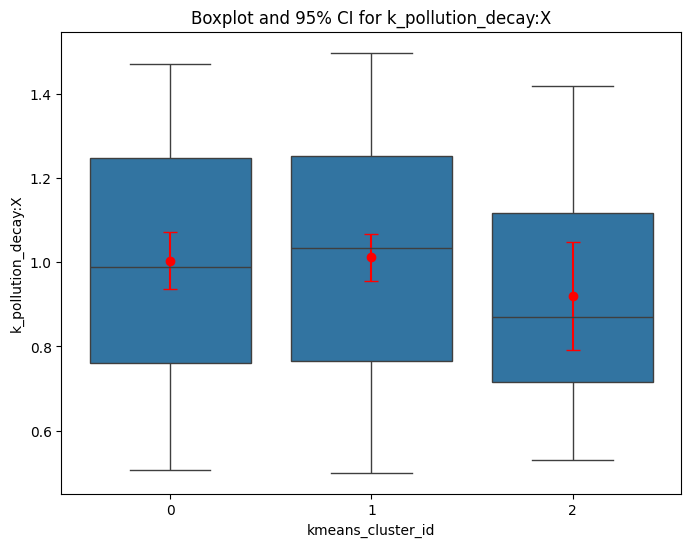

In [72]:
# Plot the confidence intervals
for variable in ci_df['variable'].unique():
    statsu.plot_boxplot_with_error_bar(exp_design_df, ci_df, variable, 'kmeans_cluster_id', conf)

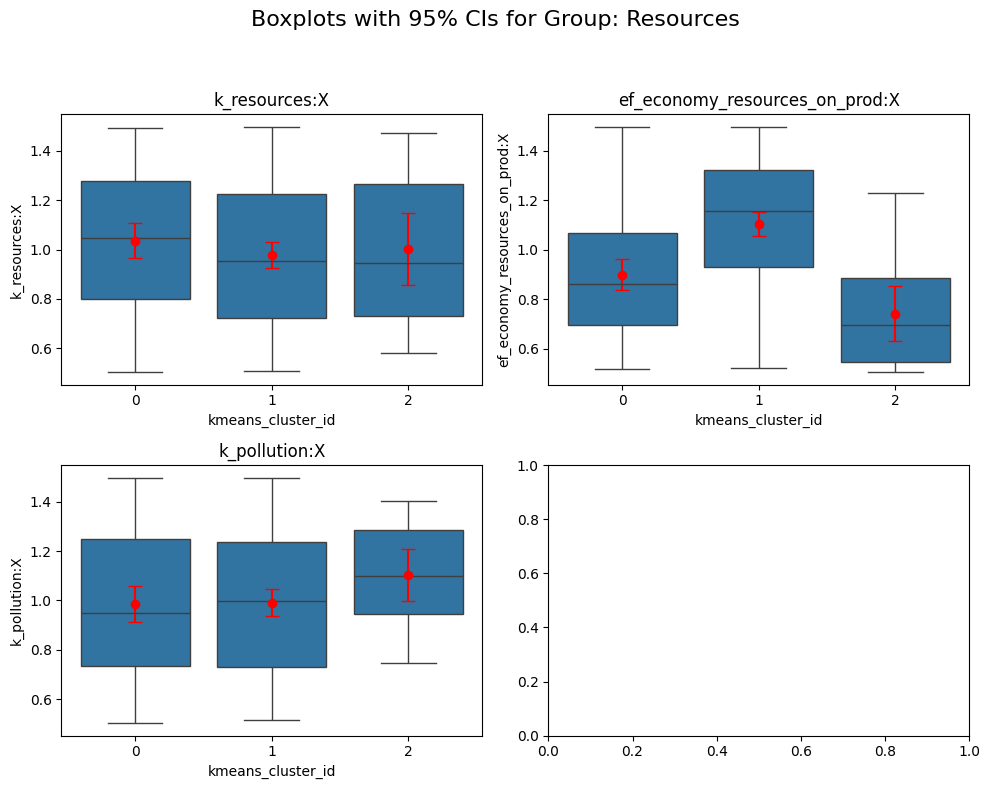

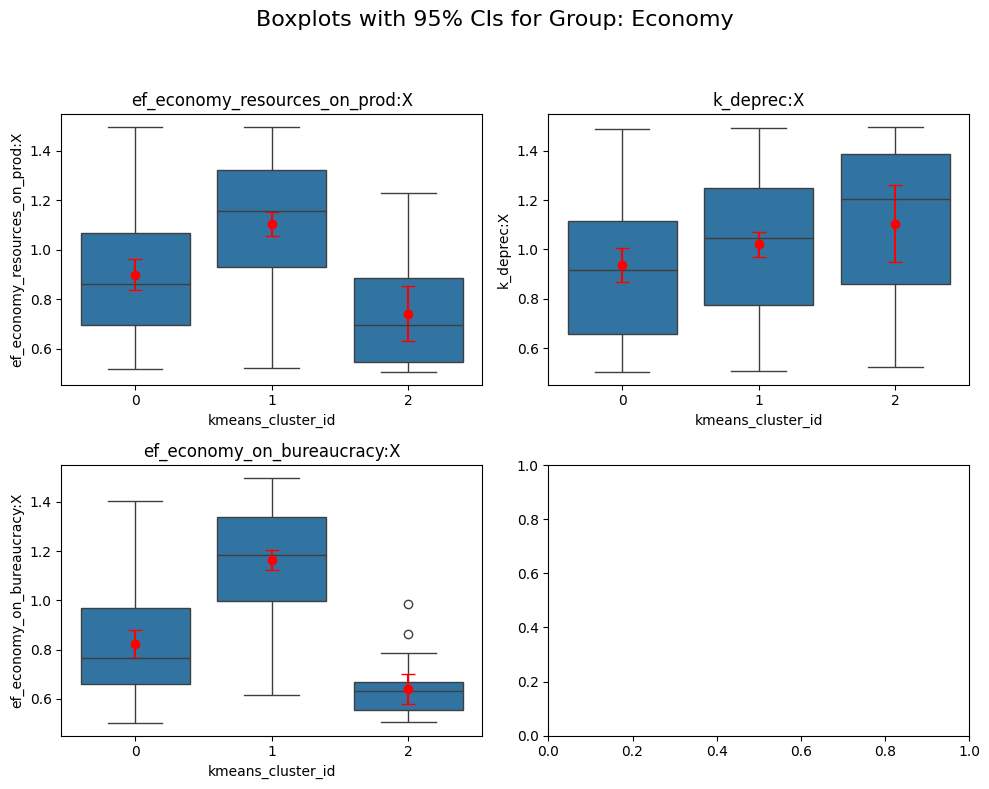

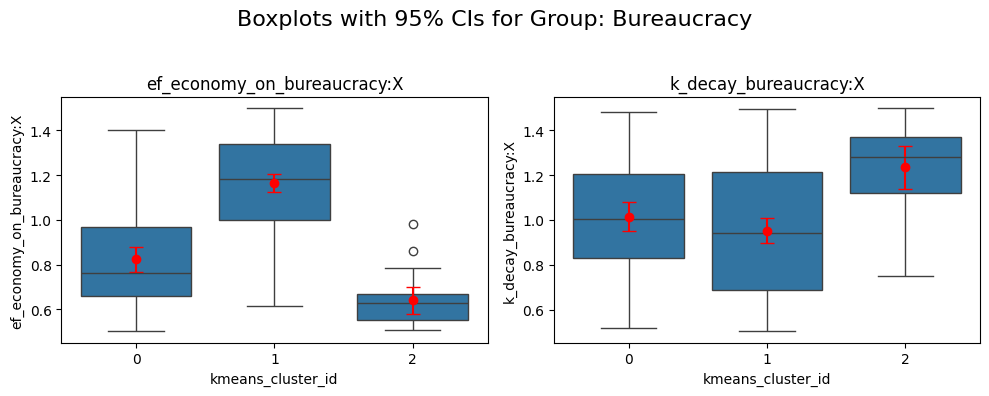

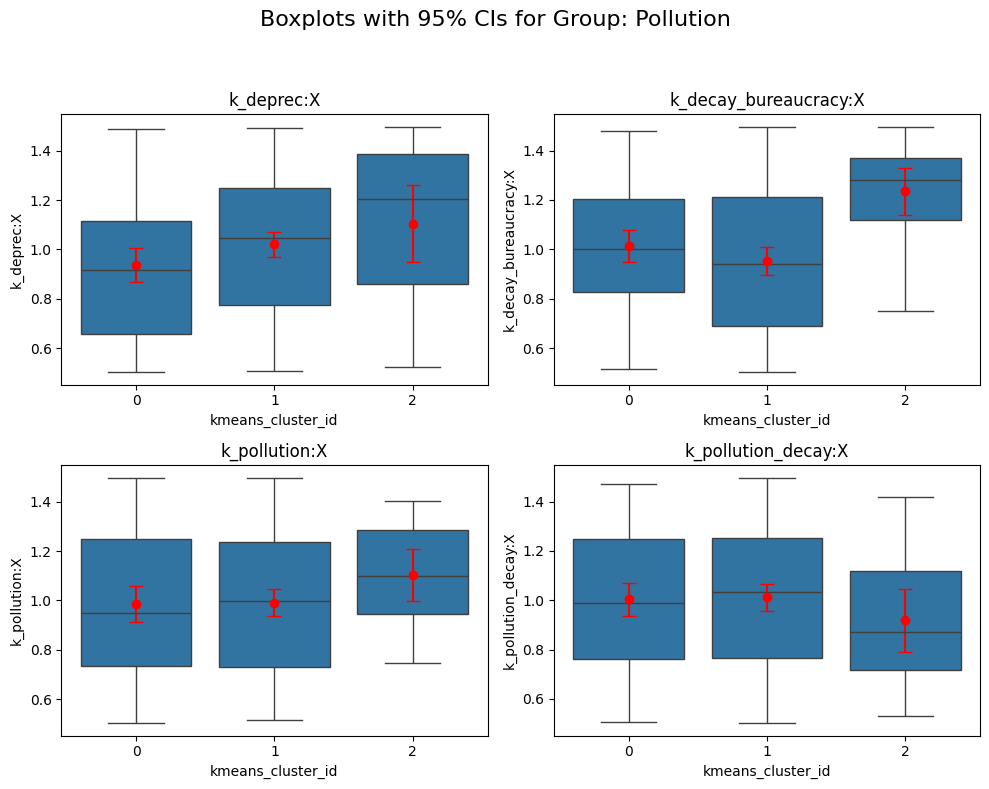

In [73]:
var_groups = {
    'resources': resources_params,
    'economy': economy_params,
    'bureaucracy': bureaucracy_params,
    'pollution': poluttion_params
}
# Plot the confidence intervals for each group
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['resources'], 'kmeans_cluster_id', 'Resources', conf)
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['economy'], 'kmeans_cluster_id', 'Economy', conf)
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['bureaucracy'], 'kmeans_cluster_id', 'Bureaucracy', conf)
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['pollution'], 'kmeans_cluster_id', 'Pollution', conf)

In [74]:
def get_summary_stats_from_exp_design(df, clustering_type='kmeans'):
    """
    Get summary stats from the experimental design data frame.
    
    Parameters:
      df (DataFrame): Input experimental design data frame.
      clustering_type (str): Type of clustering to use ('kmeans' or 'dbscan').
      
    Returns:
      DataFrame: Summary statistics with explicit column names.
    """
    # Drop run id column
    df = df.drop(columns=['run_id'])
    
    # Drop the cluster_id column not relevant to the chosen clustering type
    if clustering_type == 'kmeans':
        df = df.drop(columns=['dbscan_cluster_id'])
    elif clustering_type == 'dbscan':
        df = df.drop(columns=['kmeans_cluster_id'])
    
    # Define the aggregation functions with explicit names using the new named aggregation syntax.
    # Here we aggregate all columns (except the clustering column) with the same set of stats.
    agg_funcs = {
        'mean': 'mean',
        'median': 'median',
        'max': 'max',
        'min': 'min',
        'q1': lambda x: x.quantile(0.25),
        'q3': lambda x: x.quantile(0.75),
        'iqr': lambda x: x.quantile(0.75) - x.quantile(0.25)
    }
    
    # Identify the value columns to aggregate (all columns except the grouping column)
    group_col = f'{clustering_type}_cluster_id'
    value_columns = [col for col in df.columns if col != group_col]
    
    # Use the named aggregation feature. Since the aggregation is the same for every column,
    # we build a dictionary comprehension to apply each aggregation to every value column.
    summary_stats_df = df.groupby(group_col)[value_columns].agg(**{
        f"{col}_{stat_name}": (col, func)
        for col in value_columns
        for stat_name, func in agg_funcs.items()
    }).reset_index()
    
    return summary_stats_df


In [75]:
get_summary_stats_from_exp_design(exp_design_df)

,kmeans_cluster_id,k_resources:X_mean,k_resources:X_median,k_resources:X_max,k_resources:X_min,k_resources:X_q1,k_resources:X_q3,k_resources:X_iqr,ef_economy_resources_on_prod:X_mean,ef_economy_resources_on_prod:X_median,...,k_pollution:X_q1,k_pollution:X_q3,k_pollution:X_iqr,k_pollution_decay:X_mean,k_pollution_decay:X_median,k_pollution_decay:X_max,k_pollution_decay:X_min,k_pollution_decay:X_q1,k_pollution_decay:X_q3,k_pollution_decay:X_iqr
0,0,1.036611,1.045243,1.491256,0.502445,0.799783,1.277805,0.478021,0.898571,0.859182,...,0.734042,1.247094,0.513052,1.004018,0.988717,1.469799,0.507012,0.761679,1.247945,0.486266
1,1,0.978140,0.955339,1.498459,0.506779,0.721913,1.225690,0.503776,1.102847,1.154123,...,0.729301,1.234661,0.505360,1.011280,1.034111,1.497529,0.500651,0.765083,1.253011,0.487928
2,2,1.002154,0.946053,1.472256,0.582135,0.731839,1.266453,0.534614,0.741318,0.693535,...,0.945491,1.284398,0.338907,0.918890,0.869682,1.418546,0.530336,0.715106,1.116808,0.401702


## Visualize Clustered Time Series

In [76]:
def plot_time_series_by_variable(df: pd.DataFrame, clustering_type: str, column_to_plot: str):
    """
    Plots the time series of a specified column for each run_id,
    coloring each line according to its cluster_id.

    Parameters:
    - df: pd.DataFrame containing 'time', 'run_id', 'cluster_id', and the target column.
    - column_to_plot: str, the name of the column to plot over time.
    """
    # Get unique clusters and assign each a color
    clusters = df[clustering_type].unique()
    cluster_colors = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(clusters)}

    # Create plot
    plt.figure(figsize=(12, 6))
    for run_id, run_df in df.groupby('run_id'):
        cluster_id = run_df[clustering_type].iloc[0]
        color = cluster_colors[cluster_id]
        plt.plot(run_df['time'], run_df[column_to_plot], alpha=0.5, color=color, label=f'Cluster {cluster_id}' if f'Cluster {cluster_id}' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('Time')
    plt.ylabel(column_to_plot)
    plt.title(f'{column_to_plot} over Time by Run (colored by Cluster ID)')
    plt.legend(title='Cluster ID', loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [77]:
def plot_all_variables_subplots(df: pd.DataFrame, clustering_type: str):
    """
    Creates a 2x2 grid of subplots for the columns 'Resources', 'Economy', 'Bureaucracy', and 'Pollution',
    plotting time series for each run_id and coloring lines by cluster_id.
    """
    columns_to_plot = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']
    clusters = df[clustering_type].unique()
    cluster_colors = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(clusters)}

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    for i, column in enumerate(columns_to_plot):
        ax = axes[i]
        for run_id, run_df in df.groupby('run_id'):
            cluster_id = run_df[clustering_type].iloc[0]
            color = cluster_colors[cluster_id]
            ax.plot(run_df['time'], run_df[column], color=color)

        ax.set_title(f'{column} over Time')
        ax.set_xlabel('Time')
        ax.set_ylabel(column)
        ax.grid(True)

    # Shared legend
    handles = [plt.Line2D([0], [0], color=cluster_colors[c], label=f'Cluster {c}') for c in clusters]
    fig.legend(handles=handles, title='Cluster ID', loc='upper center', ncol=len(clusters), bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [78]:
def plot_all_clusters(df: pd.DataFrame, clustering_type: str):
    """
    Creates a grid of subplots where each subplot corresponds to a unique cluster (based on `clustering_type`).
    In each subplot, all time series for the stock variables 'Resources', 'Economy', 'Bureaucracy', and 'Pollution'
    are plotted for the runs belonging to that cluster.
    
    Parameters:
        df (pd.DataFrame): The input dataframe containing time series data, including a time column ('time'),
                           a unique run identifier ('run_id'), and a clustering column (specified by clustering_type).
        clustering_type (str): The name of the column in df that contains the cluster id for each run.
    """
    # Define the stock variables to plot.
    columns_to_plot = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']
    
    # Extract and sort unique clusters.
    clusters = sorted(df[clustering_type].unique())
    n_clusters = len(clusters)
    
    # Determine grid size using a square-like layout.
    n_cols = math.ceil(math.sqrt(n_clusters))
    n_rows = math.ceil(n_clusters / n_cols)
    
    # Create the subplots with shared axes.
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows),
                             sharex=True, sharey=True)
    # Flatten axes array for easier iteration.
    if n_clusters == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Define consistent colors for each variable.
    variable_colors = {
        'Resources': 'blue',
        'Economy': 'orange',
        'Bureaucracy': 'green',
        'Pollution': 'red'
    }
    
    # Loop over clusters to plot the series in each subplot.
    for i, cluster in enumerate(clusters):
        ax = axes[i]
        # Filter dataframe to include only runs from the current cluster.
        df_cluster = df[df[clustering_type] == cluster]
        
        # To avoid duplicate legend entries, track which variable labels have been added.
        labels_plotted = {}
        
        for run_id, run_df in df_cluster.groupby('run_id'):
            for var in columns_to_plot:
                label = None
                # Only add a label once per variable.
                if var not in labels_plotted:
                    label = var
                    labels_plotted[var] = True
                ax.plot(run_df['time'], run_df[var],
                        color=variable_colors[var],
                        label=label,
                        alpha=0.7)
        
        ax.set_title(f"Cluster {cluster}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend()
    
    # Hide any unused subplots if the grid is larger than the number of clusters.
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Enable tick labels for all subplots.
    for ax in axes:
        ax.tick_params(axis='both', labelbottom=True, labelleft=True)
    
    plt.tight_layout()
    plt.show()


In [79]:
def plot_time_series_by_cluster_subplots(df: pd.DataFrame, clustering_type: str, column_to_plot: str):
    """
    Plots time series for each cluster in separate subplots.
    Each subplot contains the time series of all run_ids in that cluster for the selected column,
    and all lines in a subplot share the same color.

    Parameters:
    - df: pd.DataFrame containing the data.
    - column_to_plot: str, the name of the column to plot.
    - title: str, optional, the title for the entire figure.
    """
    clusters = sorted(df[clustering_type].unique())
    n_clusters = len(clusters)
    n_cols = 2
    n_rows = math.ceil(n_clusters / n_cols)

    # Assign a consistent color per cluster using the updated get_cmap
    colormap = plt.get_cmap('tab10', n_clusters)
    cluster_colors = {cluster_id: colormap(i) for i, cluster_id in enumerate(clusters)}

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), squeeze=False)
    axes = axes.flatten()

    for i, cluster_id in enumerate(clusters):
        ax = axes[i]
        color = cluster_colors[cluster_id]
        cluster_df = df[df[clustering_type] == cluster_id]

        for run_id, run_df in cluster_df.groupby('run_id'):
            ax.plot(run_df['time'], run_df[column_to_plot], color=color, alpha=0.9)

        ax.set_title(f'Cluster {cluster_id}')
        ax.set_xlabel('Time')
        ax.set_ylabel(column_to_plot)
        ax.grid(True)

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Set the title for the entire figure
    fig.suptitle(f'{column_to_plot} Clusters', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
    plt.show()


In [80]:
state_variables = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']

In [88]:
# Create a dbscan df without noise rows
dbscan_df = labeled_scenarios_df[labeled_scenarios_df['dbscan_cluster_id'] != -1].copy()

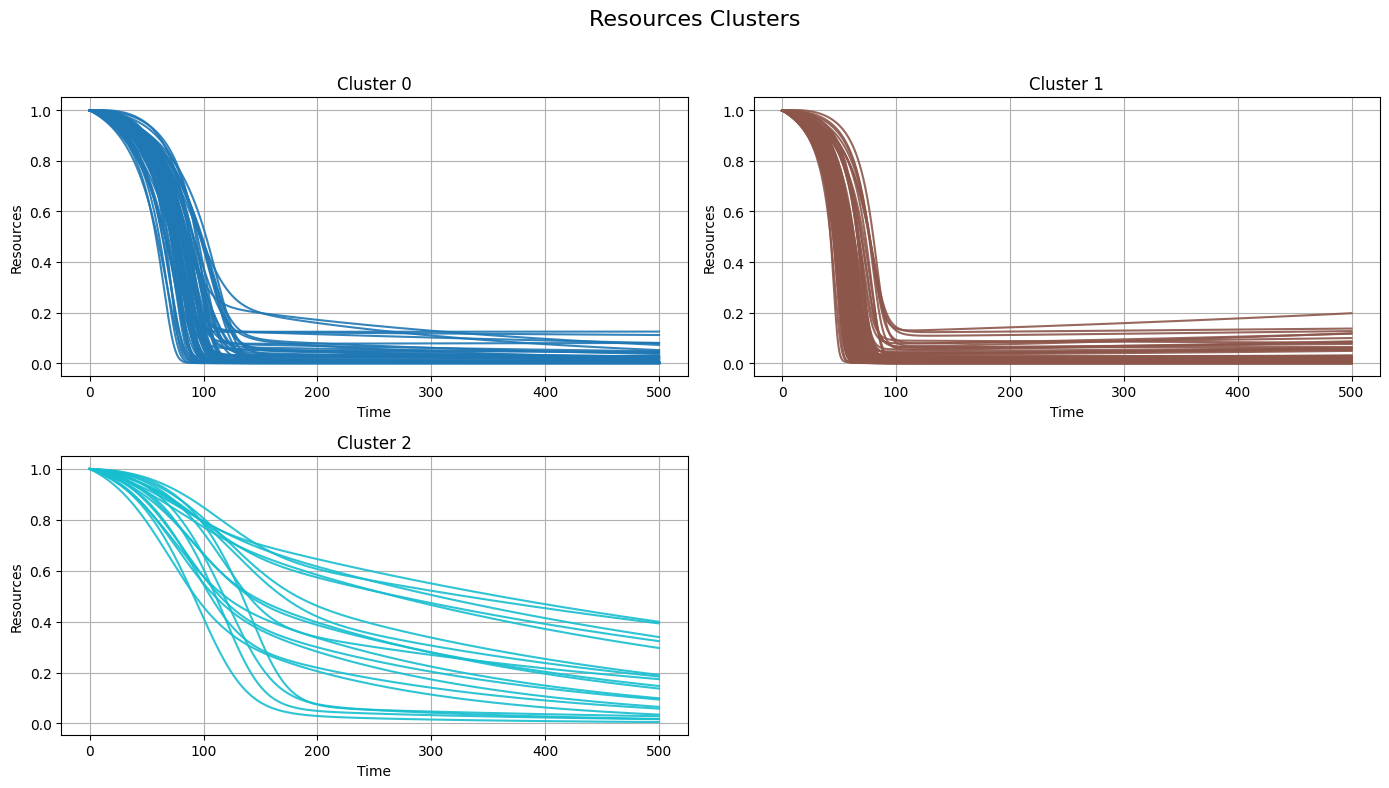

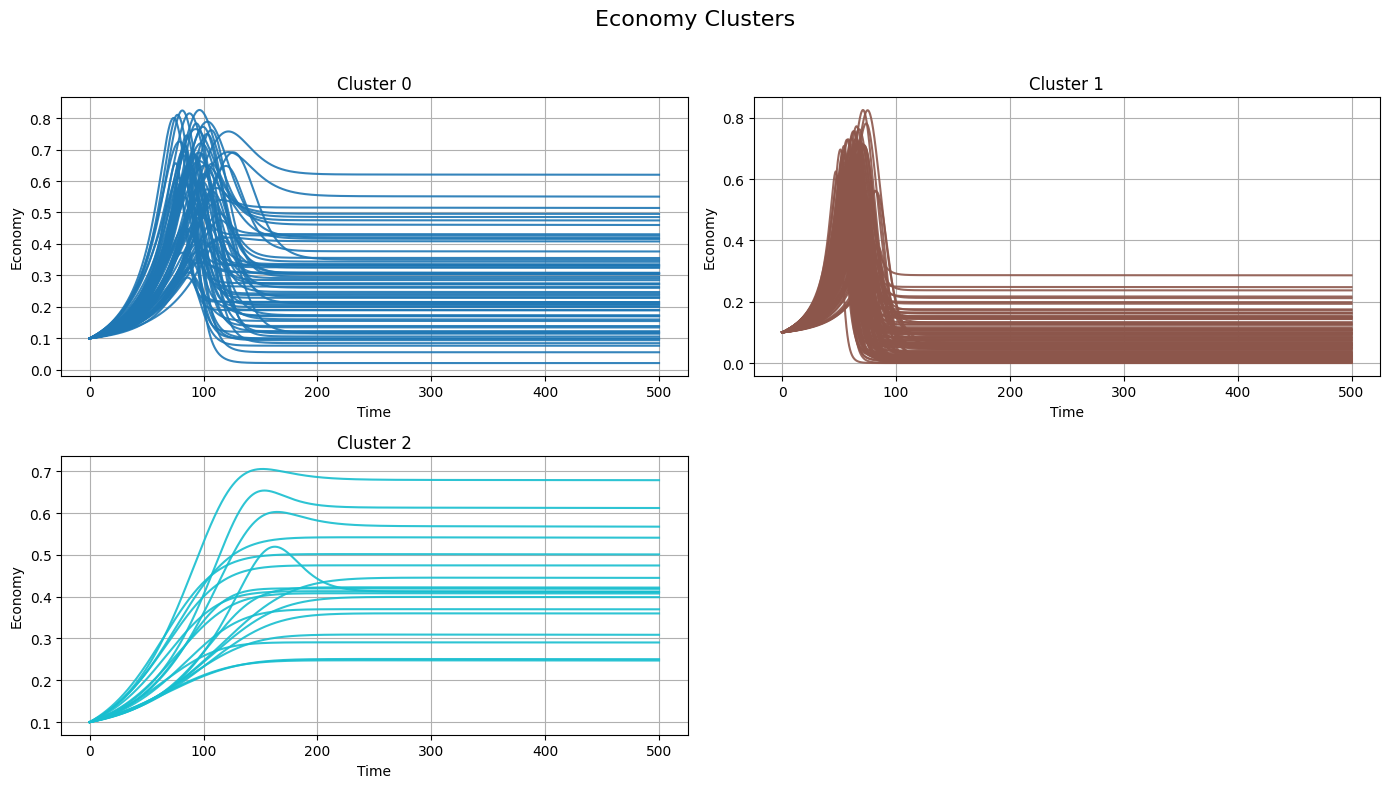

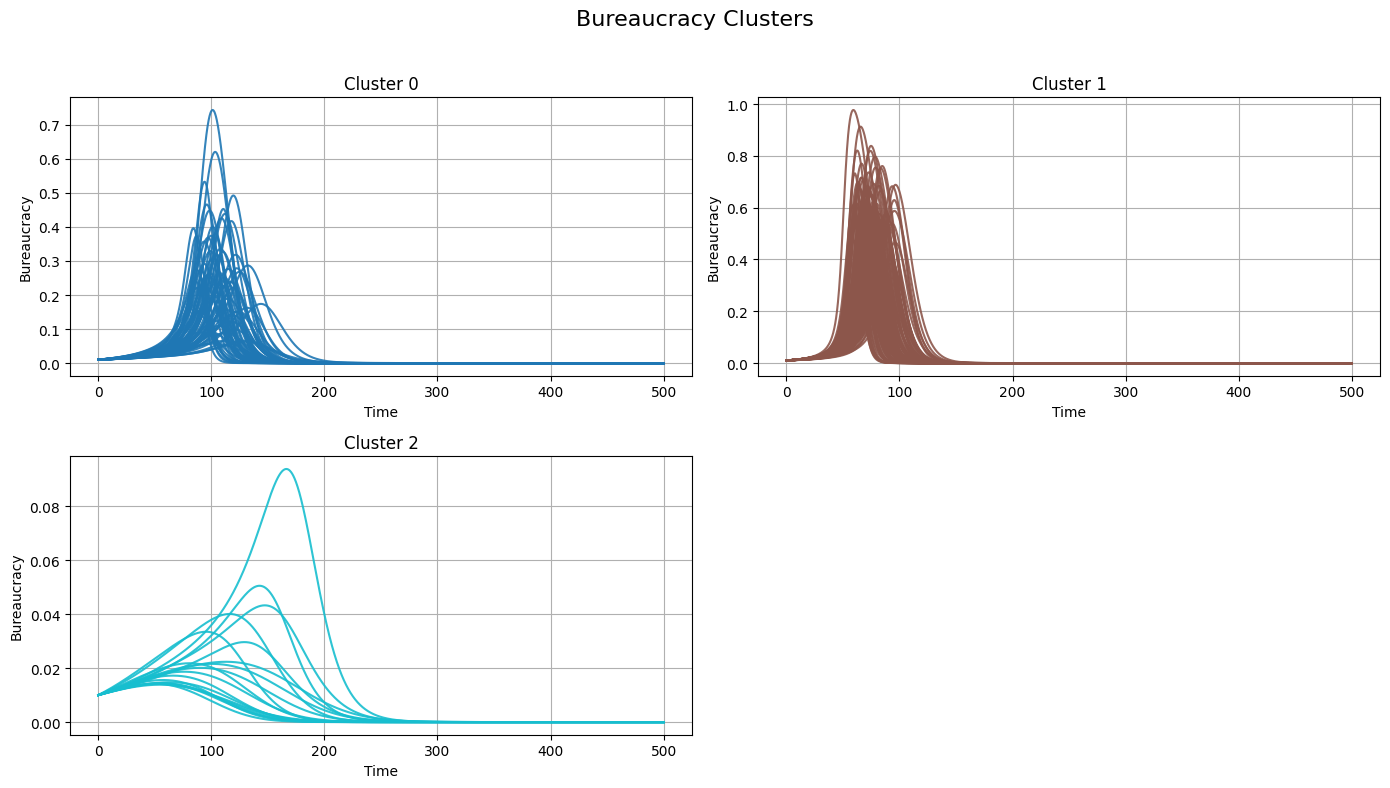

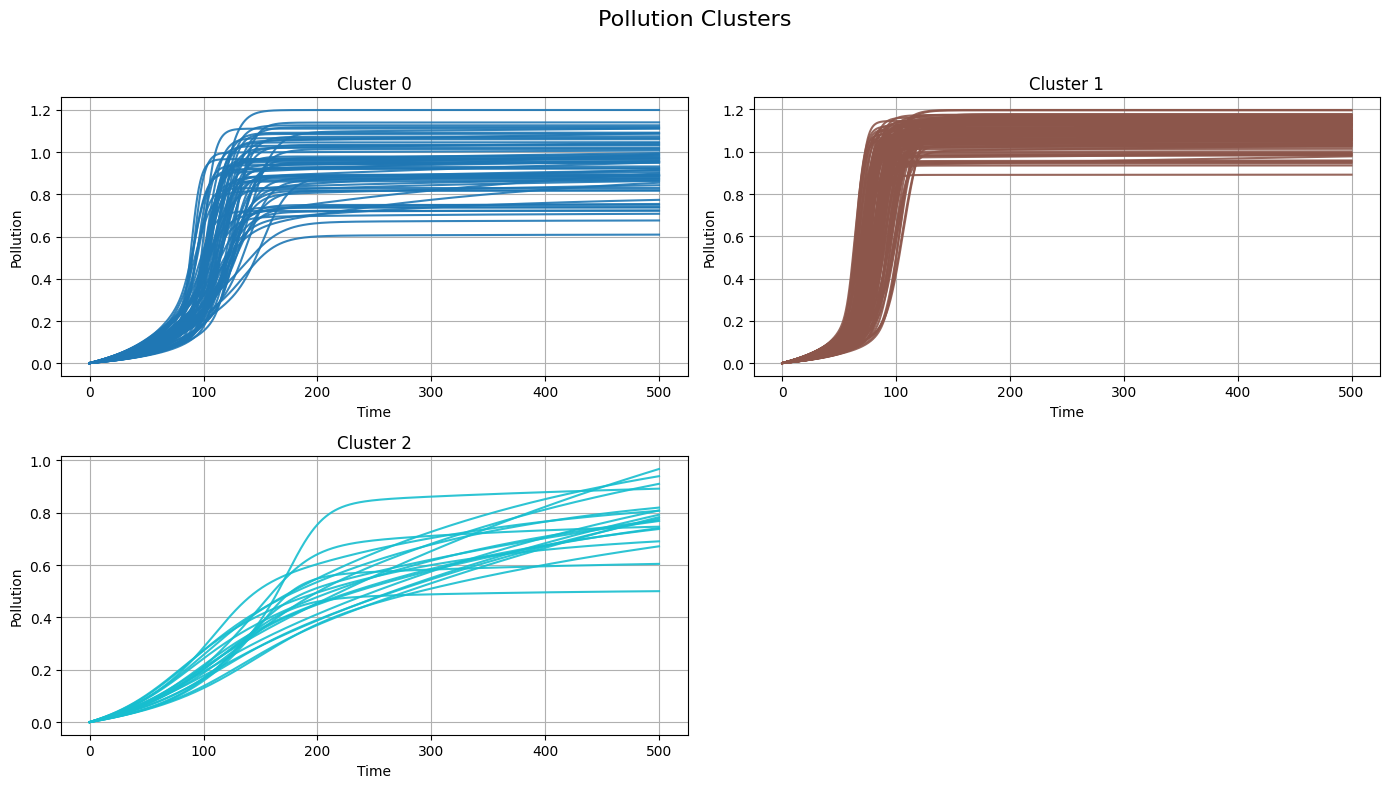

In [81]:
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Resources')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Economy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Bureaucracy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Pollution')

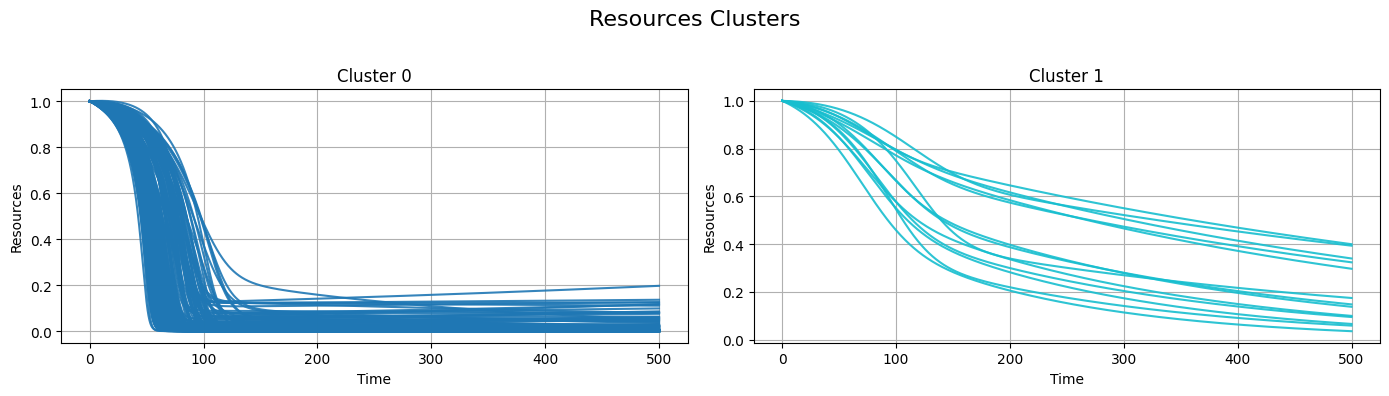

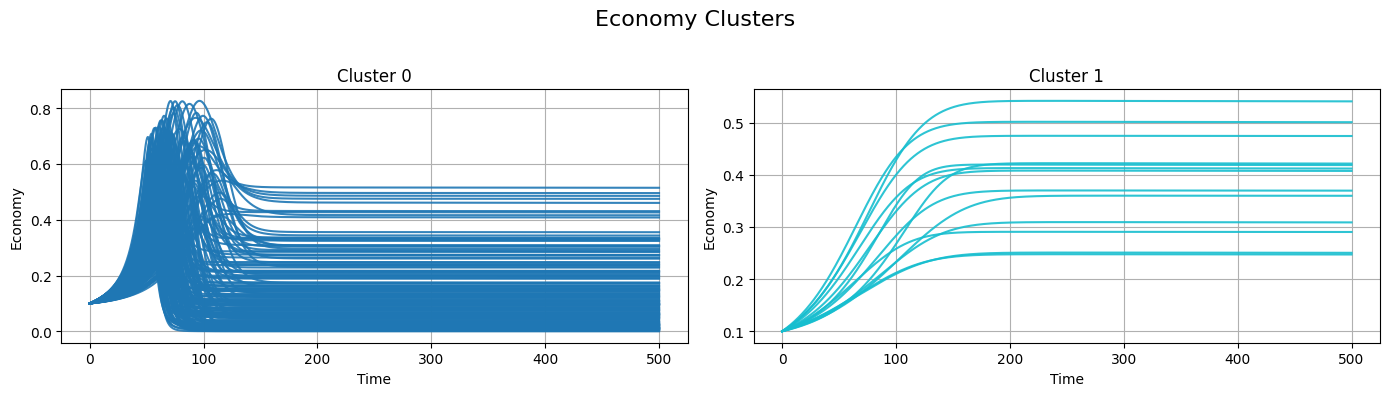

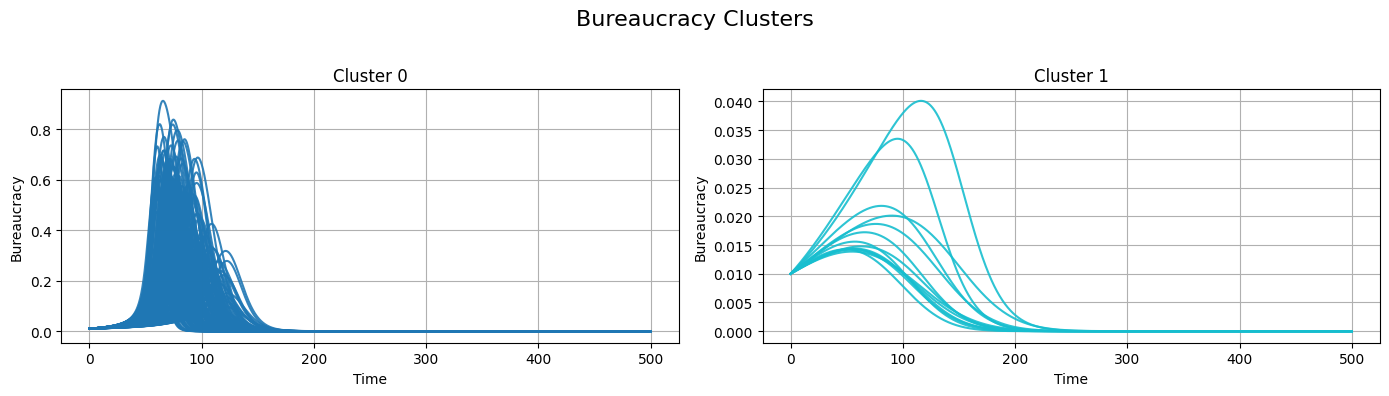

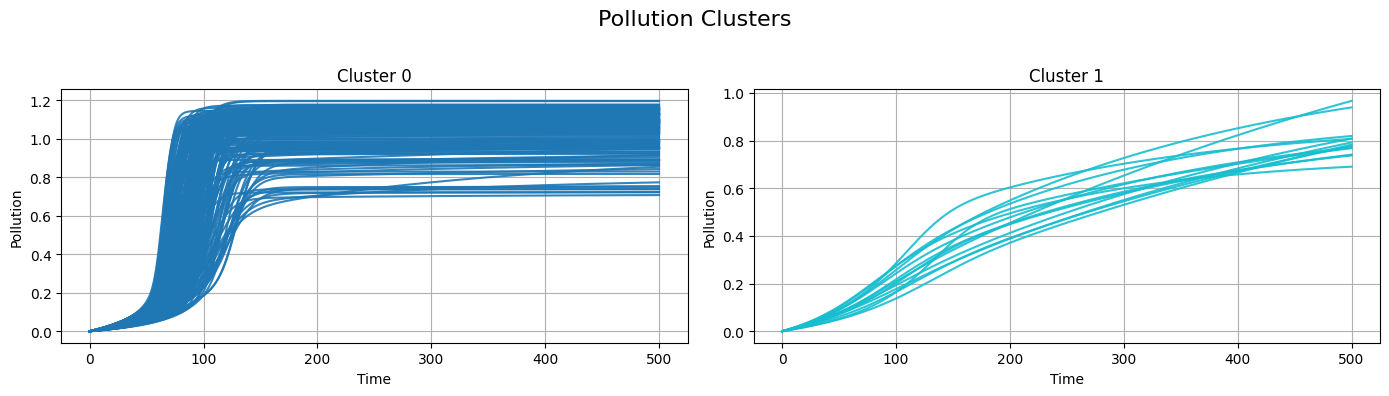

In [89]:
plot_time_series_by_cluster_subplots(dbscan_df, 'dbscan_cluster_id', 'Resources')
plot_time_series_by_cluster_subplots(dbscan_df, 'dbscan_cluster_id', 'Economy')
plot_time_series_by_cluster_subplots(dbscan_df, 'dbscan_cluster_id', 'Bureaucracy')
plot_time_series_by_cluster_subplots(dbscan_df, 'dbscan_cluster_id', 'Pollution')

In [83]:
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Resources')
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Economy')
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Bureaucracy')
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Pollution')

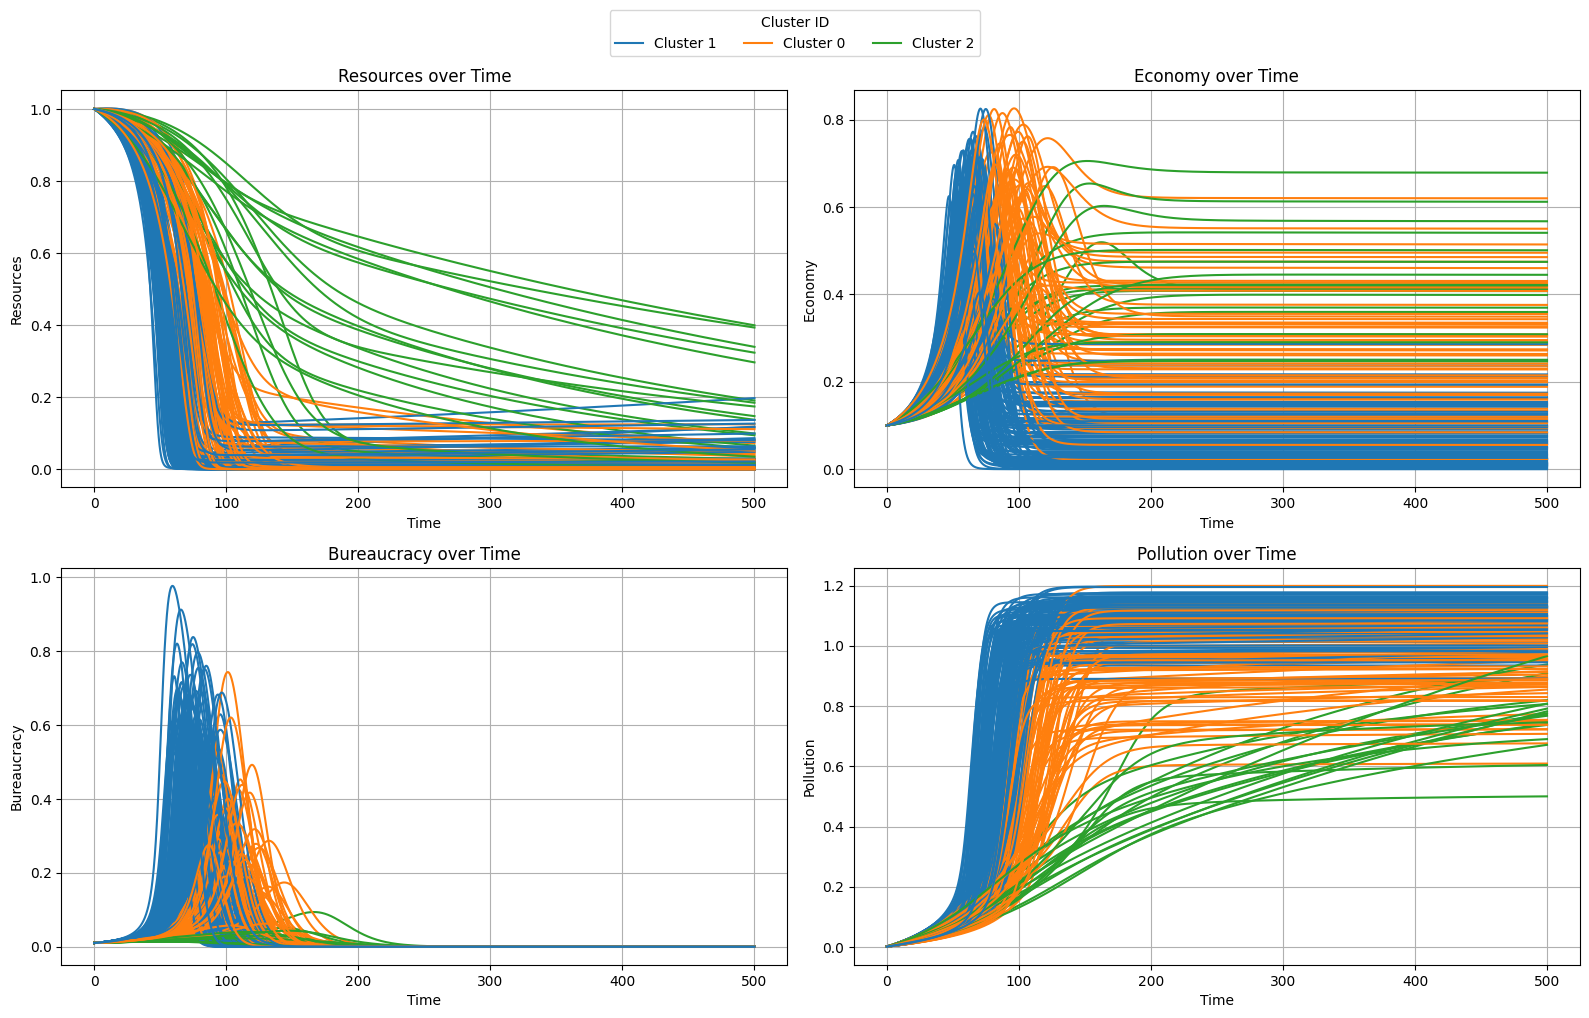

In [84]:
plot_all_variables_subplots(labeled_scenarios_df, 'kmeans_cluster_id')

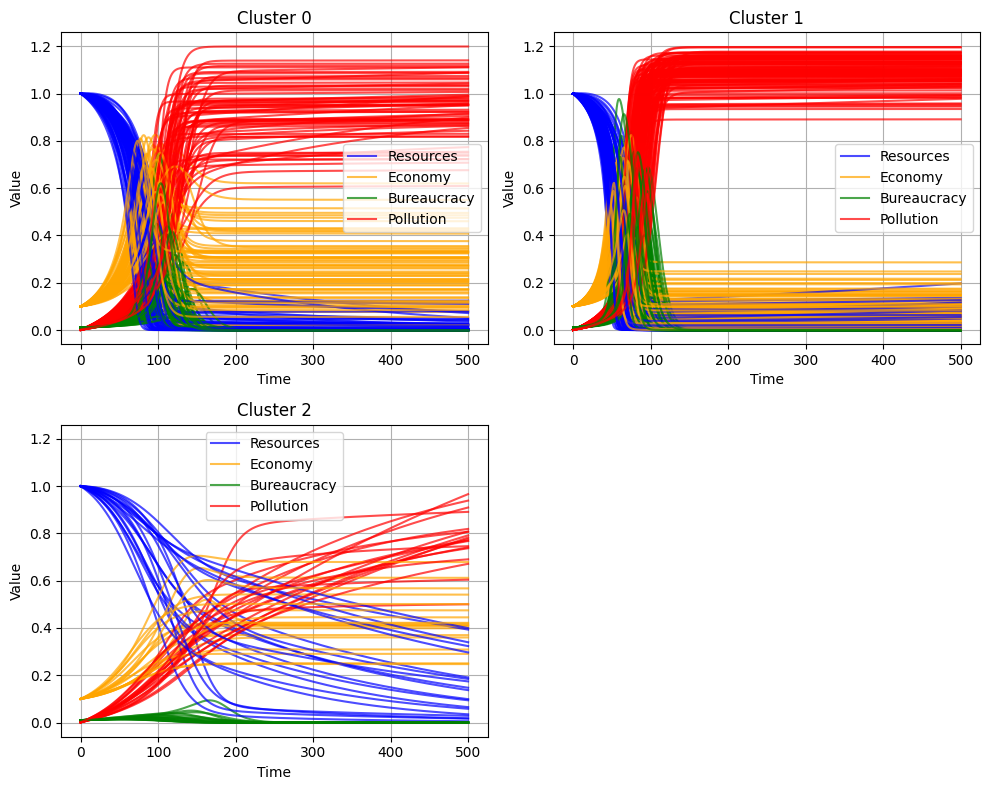

In [85]:
plot_all_clusters(labeled_scenarios_df, 'kmeans_cluster_id')

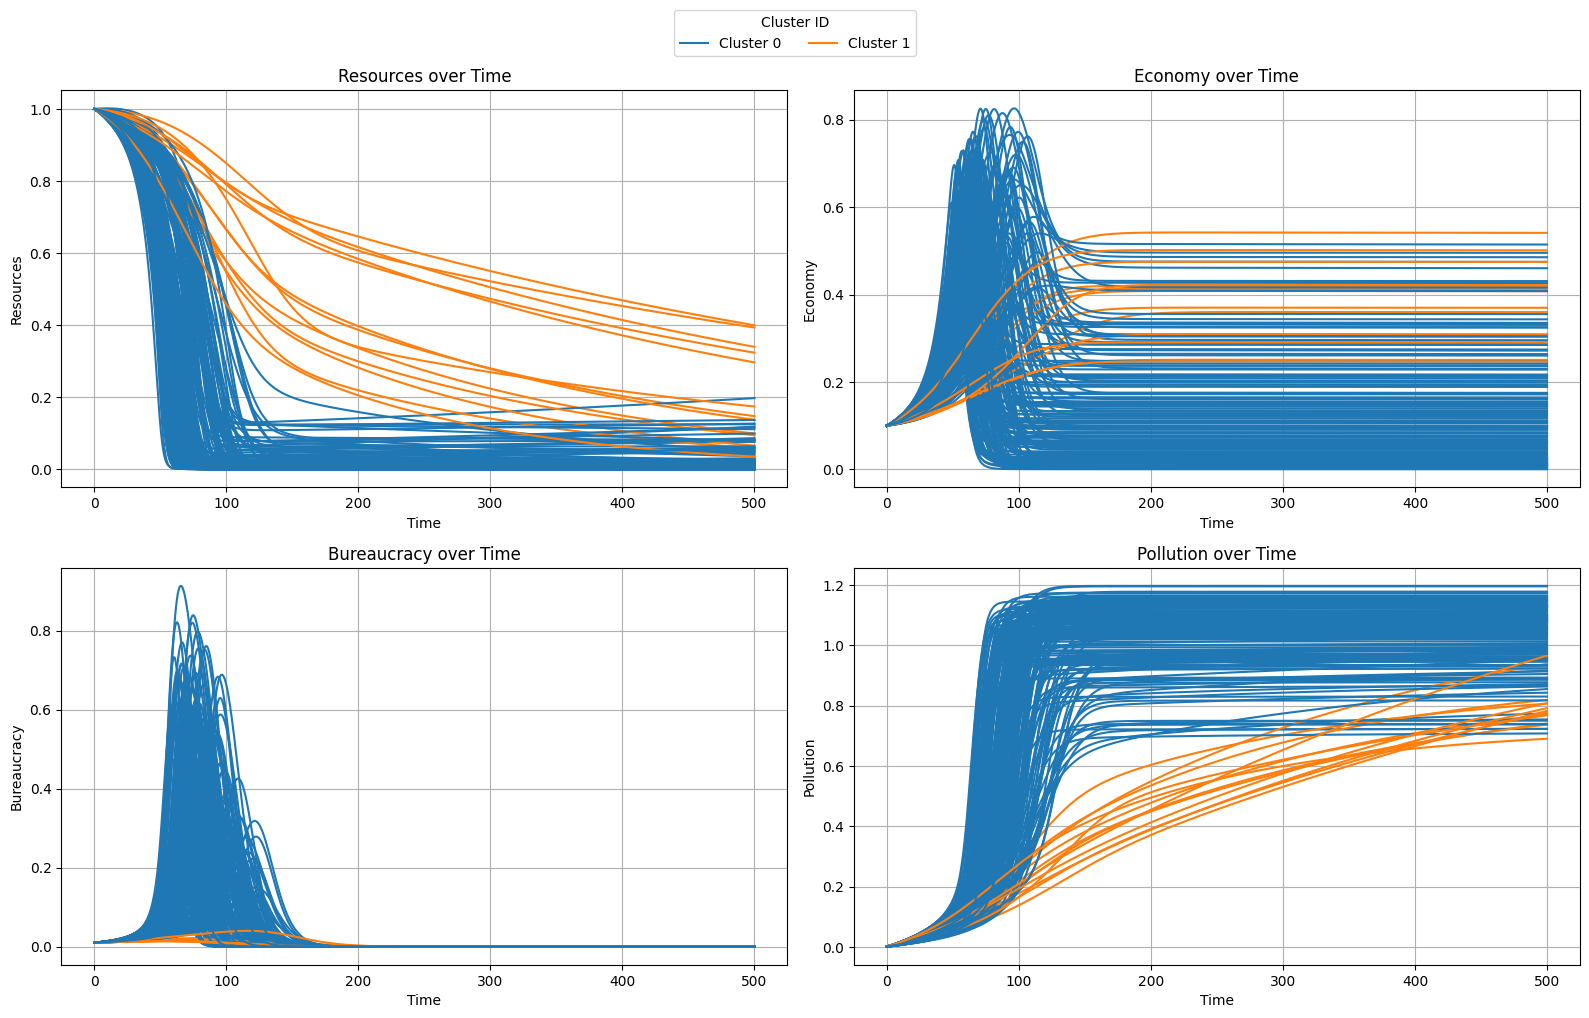

In [90]:
plot_all_variables_subplots(dbscan_df, 'dbscan_cluster_id')

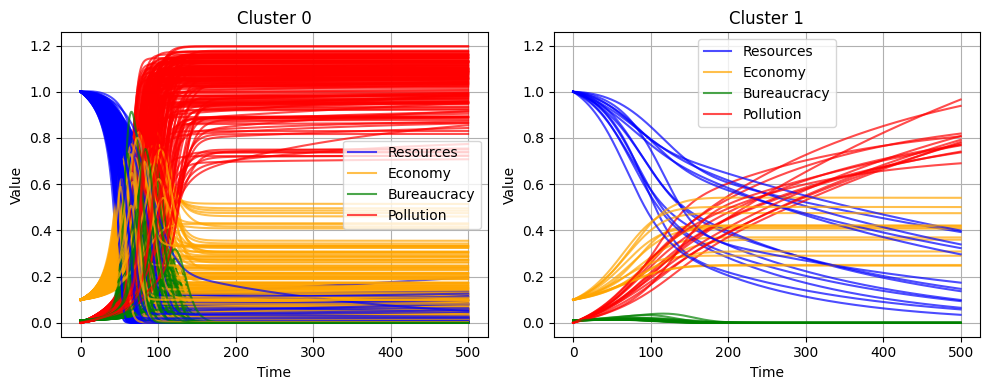

In [92]:
plot_all_clusters(dbscan_df, 'dbscan_cluster_id')